In [2]:
from google.colab import drive
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from memory_profiler import memory_usage
import timeit
import joblib
import lightgbm as lgb


##Read and merge data

In [3]:
drive.mount('/content/drive')
%cd /content/drive/My Drive/colab


Mounted at /content/drive
/content/drive/My Drive/colab


labels.csv: This file contains information about labels for reviews. Each review has its own identifier ("id") and a specified emotional rating ("sentiment"), which can be "Positive" or "Negative".

reviews.csv: This file contains the reviews themselves, where each review also has an identifier ("id") and the text of the review ("text").

In [4]:
labels_file_path = 'labels.csv'
reviews_file_path = 'reviews.csv'

labels_df = pd.read_csv(labels_file_path, delimiter=',')
reviews_df = pd.read_csv(reviews_file_path, delimiter=',')

In [5]:
labels_df

,id,sentiment
0,168,Positive
1,26,Positive
2,64,Positive
3,10,Positive
4,111,Negative
...,...,...
249,189,Positive
250,72,Positive
251,107,Positive
252,271,Positive


In [6]:
reviews_df

,id,text
0,168,"Hi Leah, I ordered this early to give to a co-..."
1,26,"Good evening, \n I just received my order! I ..."
2,64,I couldn’t find where I could write a review b...
3,10,I received my order today and gave it to my si...
4,111,"﻿Max,\n\nWe received the heart but sadly are d..."
...,...,...
249,189,"Thank you, this is beautiful and they loved it."
250,72,Thanks so much. They lookgreat!
251,107,"Emily, \n THANK YOU so much for the new “bric..."
252,271,"Jacqueline, \n I just received the replaceme..."


In [7]:
df = pd.merge(reviews_df, labels_df, on='id', how='inner')
df.head()

,id,text,sentiment
0,168,"Hi Leah, I ordered this early to give to a co-...",Positive
1,26,"Good evening, \n I just received my order! I ...",Positive
2,64,I couldn’t find where I could write a review b...,Positive
3,10,I received my order today and gave it to my si...,Positive
4,111,"﻿Max,\n\nWe received the heart but sadly are d...",Negative


##Initial analysis

Check for duplicates

In [8]:
duplicates = df[df.duplicated(subset=['text'])]
print("Number of duplicates: ", len(duplicates))

Number of duplicates:  1


Checking for missing data

In [9]:
missing_data = df.isnull().sum()
print("Missing data:\n", missing_data)

Missing data:
 id           0
text         0
sentiment    0
dtype: int64


Viewing anomalies

In [10]:
df['text_length'] = df['text'].apply(len)
anomalies = df[(df['text_length'] < 10) | (df['text_length'] > 1000)]
print("Potential anomalies:\n", anomalies[['id', 'text_length']])

Potential anomalies:
       id  text_length
69    31         1449
131  240         1312


Let's take a closer look at this data df.text[69] df.text[131]

In [11]:
df.text[69]

'Mr. Lans, \n  Thank you for this email and the opportunity to let you know about the finished product that I received yesterday. My husband Christopher, helped me order this item gift for a good friend who lost her daughter Kimberly. I’ve ordered these 3D products before with wonderful results, but I’m wondering now if maybe it was from a different company because I must tell you I was VERY disappointed with the end result of this one. It’s very hard to see exactly what the finished product is going to look like on a computer screen, so thought choosing the heart design would work. But it didn’t at all. The bottom of the heart looks like it’s making a “dent” in the top of Kimberly’s head. So there is no way I could possibility send this to my friend. I think your system should be able to advise you if the image submitted would not be a good fit and allow you to either choose a different item or perhaps suggest you selected a larger size heart. If given the choice, (for only $20 more) 

In [12]:
df.text[131]

"Adam, \n\n The towers we gave at Christmas gifts or warmly and passionately received. They loved them as my wife did hers. We wrote a wonderful review but we have not seen it on your website. We would be most happy to do it again if you would send us a link or instructions. Thank you again! \n\n Brendan \n\n Sent from my iPhone\n\nBrendan Lillard \n\n Arthur J. Gallagher & Co.\n\n12 E Central | Port Jefferybury, LA 74354\n\nMobile: 992-584-3185\n\nalexandria17@yahoo.com\n\njames81@yahoo.com\n\n \n\nThe intent of this analysis is to provide you with general information regarding the status of, and/or potential concerns related to, your current employee benefits issue. It does not necessarily fully address all your specific issues. It should not be construed as, nor is it intended to provide, legal advice. Questions regarding specific issues should be addressed by the client's general counsel or an attorney who specializes in this practice area. \n\n \n\nThis e-mail and any files transm

These are our outliers, and we can either manually correct the data or delete it

In [13]:
df = df.drop(131)
df = df.drop(69)


Let's take a closer look at our duplicates

In [14]:
duplicate_rows = df[df.duplicated(subset=['text'], keep=False)]
print("Duplicates found:")
print(duplicate_rows)

Duplicates found:
      id                                               text sentiment  \
121  309  I just received my item and it is absolutely M...  Positive   
177   12  I just received my item and it is absolutely M...  Positive   

     text_length  
121           92  
177           92  


Deleting a duplicate at index 177. Checking that the duplicate has been deleted


In [15]:
df.drop(177, inplace=True)

print("Number of duplicates after deletion: ", len(df[df.duplicated(subset=['text'])]))

Number of duplicates after deletion:  0


Class distribution. Displaying the distribution of classes and graph of class distribution


Class distribution:
Positive    150
Negative    101
Name: sentiment, dtype: int64


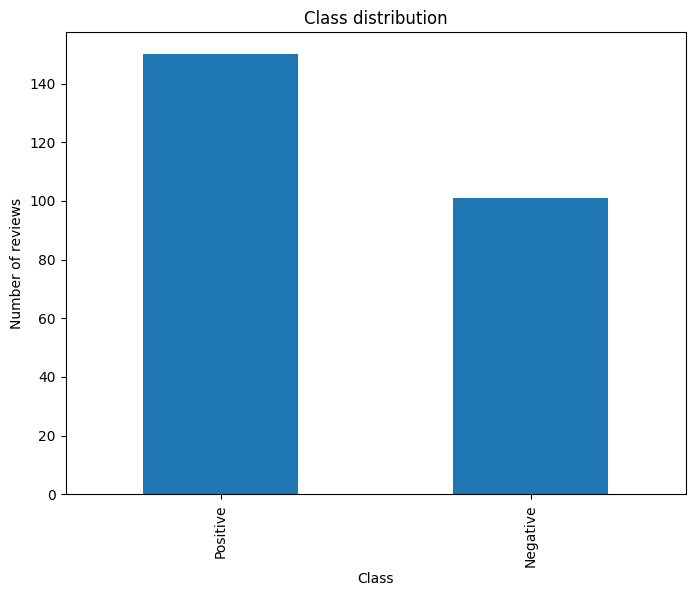

In [16]:
class_distribution = df['sentiment'].value_counts()

print("Class distribution:")
print(class_distribution)

class_distribution.plot(kind='bar', figsize=(8, 6))
plt.title('Class distribution')
plt.xlabel('Class')
plt.ylabel('Number of reviews')
plt.show()

Given your task, to balance the unbalanced classes in the task of classifying user reviews into positive and negative, I will use Stratified Sampling to create a balanced dataset for training the model.

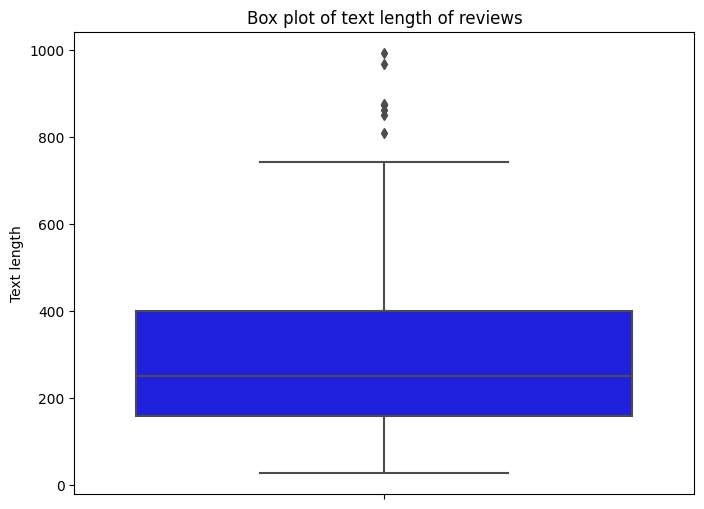

In [17]:
plt.figure(figsize=(8, 6))
sns.boxplot(y='text_length', data=df, color='b')
plt.title('Box plot of text length of reviews')
plt.ylabel('Text length')
plt.show()

On the boxplot, we can also see the existing emissions. Text length 800-1000

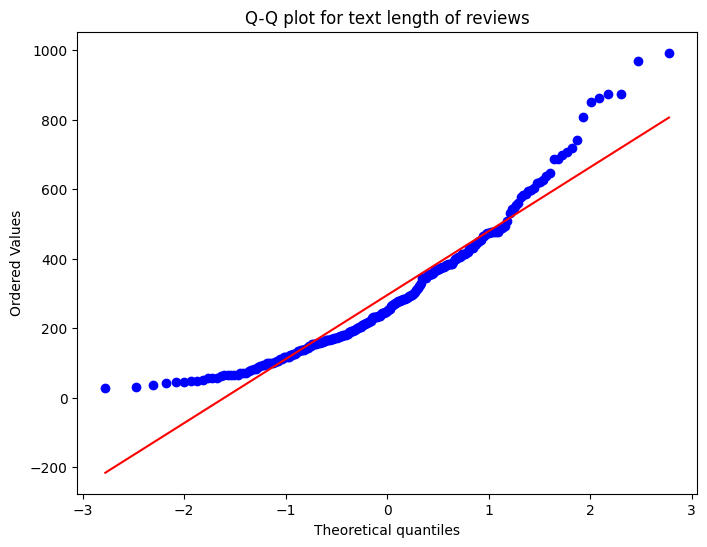

In [18]:
plt.figure(figsize=(8, 6))
stats.probplot(df['text_length'], dist="norm", plot=plt)
plt.title('Q-Q plot for text length of reviews')
plt.show()

If the data in the Q-Q plot is first above the line (dotted line), then drops below and rises above again, this may indicate **the presence of heavy tails** in the distribution of review text lengths.
In this case, the model may be less accurate because it may not handle large outliers or abnormal values well.

Since we already have a limited amount of data, which may not be enough to train the model, I will try to keep all the data and train on it.

This code block contains a function that allows you to highlight and visualize the most frequently occurring words in the dataset texts:

In [19]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

In [20]:
common_words = get_top_n_words(df['text'].tolist(), 20)
df1 = pd.DataFrame(common_words, columns=['ReviewText', 'count'])
fig = px.bar(df1, x='ReviewText', y='count', title='Top 20 words in Texts')
fig.show()

##Data preparation

In [21]:
df[["text", "sentiment"]].describe(include='all')
#statistical description of two columns

,text,sentiment
count,251,251
unique,251,2
top,"Hi Leah, I ordered this early to give to a co-...",Positive
freq,1,150


In [23]:
# Remove all URLs, replace by URL
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'URL',str(text))


# Remove HTML beacon
def remove_HTML(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

# Remove non printable characters
def remove_not_ASCII(text):
    text = ''.join([word for word in text if word in string.printable])
    return text

# Remove @ and mention, replace by USER
def remove_mention(text):
    at=re.compile(r'@\S+')
    return at.sub(r'USER',text)


# Remove numbers, replace it by NUMBER
def remove_number(text):
    num = re.compile(r'[-+]?[.\d]*[\d]+[:,.\d]*')
    return num.sub(r'NUMBER', text)



# Replace some others smileys with SADFACE
def transcription_sad(text):
    eyes = "[8:=;]"
    nose = "['`\-]"
    smiley = re.compile(r'[8:=;][\'\-]?[(\\/]')
    return smiley.sub(r'SADFACE', text)


# Replace some smileys with SMILE
def transcription_smile(text):
    eyes = "[8:=;]"
    nose = "['`\-]"
    smiley = re.compile(r'[8:=;][\'\-]?[)dDp]')
    #smiley = re.compile(r'#{eyes}#{nose}[)d]+|[)d]+#{nose}#{eyes}/i')
    return smiley.sub(r'SMILE', text)


# Replace <3 with HEART
def transcription_heart(text):
    heart = re.compile(r'<3')
    return heart.sub(r'HEART', text)


# Factorize elongated words, add ELONG
def remove_elongated_words(text):
    rep = re.compile(r'\b(\S*?)([a-z])\2{2,}\b')
    return rep.sub(r'\1\2 ELONG', text)


# Factorize repeated punctuation, add REPEAT
def remove_repeat_punct(text):
    rep = re.compile(r'([!?.]){2,}')
    return rep.sub(r'\1 REPEAT', text)



# Remove all punctuations
def remove_all_punct(text):
    table = str.maketrans('','',string.punctuation)
    return text.translate(table)


# Remove punctuations
def remove_punct(text):
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`"
    for p in punctuations:
        text = text.replace(p, f' {p} ')

    text = text.replace('...', ' ... ')
    if '...' not in text:
        text = text.replace('..', ' ... ')
    return text
# Remove all english stopwords
def remove_stopwords(text):
    text = ' '.join([word for word in text.split() if word not in stopwords.words("english")])
    return text

def stemming(text):
    ps = PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

def lemmatization(text):
    lm= WordNetLemmatizer()
    text = ' '.join([lm.lemmatize(word, pos='v') for word in text.split()])
    return text


In [24]:
def clean_text(text):

    # Remove non text
    text = remove_URL(text)
    text = remove_HTML(text)
    text = remove_not_ASCII(text)

    # Lower text, replace abbreviations
    text = remove_mention(text)
    text = remove_number(text)

    # Remove  smileys

    text = transcription_sad(text)
    text = transcription_smile(text)
    text = transcription_heart(text)

    # Remove repeated puntuations / words
    text = remove_elongated_words(text)
    text = remove_repeat_punct(text)

    text = remove_all_punct(text)
    text = remove_punct(text)
    text = lemmatization(text)
    text = text.lower()

    return text

In [25]:
df["text"]
#text to be processed


0      Hi Leah, I ordered this early to give to a co-...
1      Good evening, \n  I just received my order! I ...
2      I couldn’t find where I could write a review b...
3      I received my order today and gave it to my si...
4      ﻿Max,\n\nWe received the heart but sadly are d...
                             ...                        
249      Thank you, this is beautiful and they loved it.
250                      Thanks so much. They lookgreat!
251    Emily, \n  THANK YOU so much for the new “bric...
252    Jacqueline,  \n  I just received the replaceme...
253    Order #(857)982-509708\nI just received my ord...
Name: text, Length: 251, dtype: object

In [26]:
nltk.download('wordnet')
df["text"] = df["text"].apply(clean_text)
df["text"]
#text after processing using functions from a file ...

[nltk_data] Downloading package wordnet to /root/nltk_data...


0      hi leah i order this early to give to a cowork...
1      good even i just receive my order i have to sa...
2      i couldnt find where i could write a review bu...
3      i receive my order today and give it to my sis...
4      max we receive the heart but sadly be disappoi...
                             ...                        
249         thank you this be beautiful and they love it
250                        thanks so much they lookgreat
251    emily thank you so much for the new brick item...
252    jacqueline i just receive the replacement base...
253    order numbernumbernumber i just receive my ord...
Name: text, Length: 251, dtype: object

In [27]:
g=[]
for i in df['text']:
    g.append(i)
maxl = max([len(s) for s in g])
print ('Maximum sequence length in the list of sentences:', maxl)

Maximum sequence length in the list of sentences: 913


text vectorization(TfidfVectorizer):

In [29]:
tfid = TfidfVectorizer()
X = tfid.fit_transform(df['text'])

In [30]:
print("X shape:", X.shape)
print("x:", X.toarray())


X shape: (251, 1695)
x: [[0.         0.12080876 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [31]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['sentiment'])


In [32]:
print("Size y:", len(y))
print("y:", y)

Size y: 251
y: [1 1 1 1 0 1 0 0 1 1 0 0 1 1 0 1 1 1 0 1 1 0 0 0 1 1 1 1 1 1 1 0 1 0 1 0 0
 0 1 0 1 1 1 1 1 0 0 1 1 1 1 0 1 0 0 1 0 0 0 1 0 0 1 1 1 1 1 0 1 0 1 1 0 1
 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 0 0 1 1 0 0 0 1 0 0 0 0 1 1 1 1 1 0
 1 1 1 0 1 1 0 1 1 1 1 1 1 1 0 1 0 1 0 0 0 1 0 1 0 0 0 1 0 0 1 0 0 0 1 1 0
 1 0 1 0 1 1 1 1 1 1 0 1 1 1 0 0 1 0 0 0 1 0 1 0 0 1 0 1 1 1 1 1 0 0 0 0 0
 0 0 1 1 1 0 1 1 1 0 1 0 1 0 0 1 0 1 0 1 0 1 1 0 0 0 0 1 0 1 1 1 1 1 1 1 1
 1 0 0 1 1 0 1 1 1 1 0 0 1 0 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1]


##Model selection

Splitting data into training and validation samples while maintaining class balance


In [33]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


Creating a list of models

In [34]:
models = [
    ('Logistic Regression', LogisticRegression()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('LightGBM', LGBMClassifier()),
    ('Naive Bayes', MultinomialNB()),
    ('Support Vector Machine', SVC())
]

In [35]:
model_names = []
balanced_accuracies = []
precisions = []
recalls = []
f1_scores = []

Search for models and train and evaluate them on a validation set

In [36]:

for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    balanced_accuracy = balanced_accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)

    model_names.append(name)
    balanced_accuracies.append(balanced_accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

[LightGBM] [Info] Number of positive: 120, number of negative: 80
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1405
[LightGBM] [Info] Number of data points in the train set: 200, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.600000 -> initscore=0.405465
[LightGBM] [Info] Start training from score 0.405465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

In [37]:
metrics_df = pd.DataFrame({
    'Model': model_names,
    'Balanced Accuracy': balanced_accuracies,
    'Precision': precisions,
    'Recall': recalls,
    'F1-Score': f1_scores
})

print(metrics_df)

                    Model  Balanced Accuracy  Precision    Recall  F1-Score
0     Logistic Regression           0.952381   0.937500  1.000000  0.967742
1           Decision Tree           0.966667   1.000000  0.933333  0.965517
2           Random Forest           0.942857   0.965517  0.933333  0.949153
3                LightGBM           0.983333   1.000000  0.966667  0.983051
4             Naive Bayes           0.833333   0.810811  1.000000  0.895522
5  Support Vector Machine           0.959524   0.966667  0.966667  0.966667


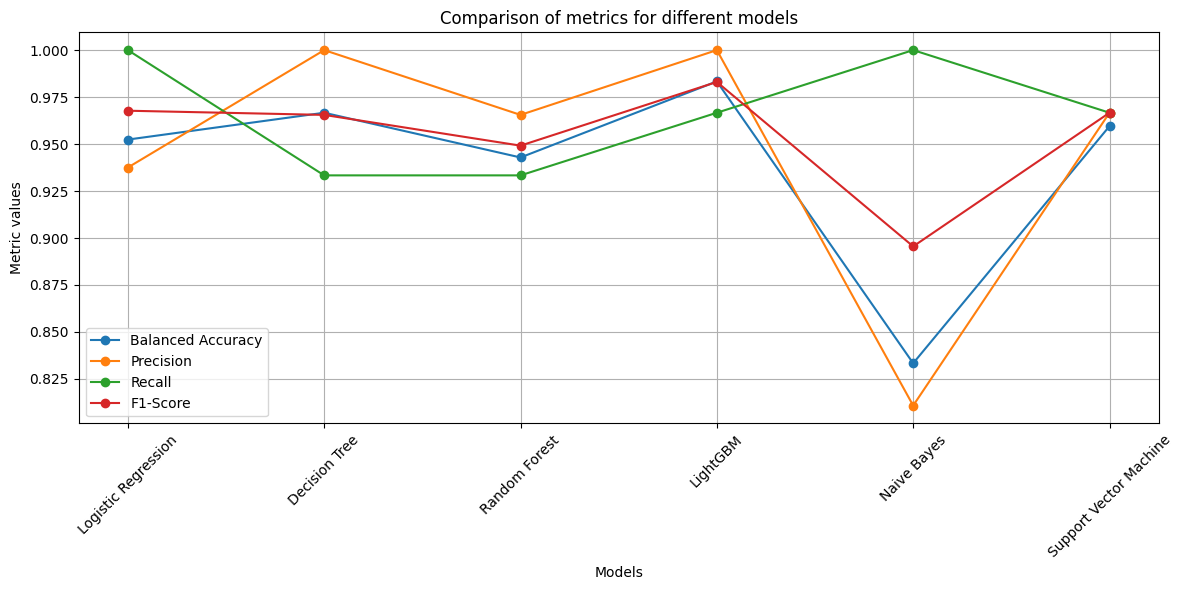

In [41]:
data = {
    'Model': [
        "Logistic Regression",
        'Decision Tree',
        'Random Forest',
        'LightGBM',
        'Naive Bayes',
        'Support Vector Machine'
    ],
    'Balanced Accuracy': [0.952381, 0.966667, 0.942857, 0.983333, 0.833333, 0.959524],
    'Precision': [0.937500, 1.000000, 0.965517, 1.000000, 0.810811, 0.966667],
    'Recall': [1.000000, 0.933333, 0.933333, 0.966667, 1.000000, 0.966667],
    'F1-Score': [0.967742, 0.965517, 0.949153, 0.983051, 0.895522, 0.966667]
}
df = pd.DataFrame(data)
plt.figure(figsize=(12, 6))

for metric in ['Balanced Accuracy', 'Precision', 'Recall', 'F1-Score']:
    plt.plot(df['Model'], df[metric], marker='o', label=metric)

plt.title('Comparison of metrics for different models')
plt.xlabel('Models')
plt.ylabel('Metric values')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout()
plt.show()

Based on the presented model metrics, I chose the Random Forest model for further experiments and use in the solution.

1. The Random Forest model has a high balanced accuracy, which means that it works well for both the positive and negative feedback classes.
2. "Random Forest is known for its efficiency and ability to run on lower-level machines. It does not require significant computing power, which meets the requirements of the task in terms of efficiency.
3. The Random Forest model does not require preliminary training on a large amount of data or the use of complex approaches to data preparation.
